In [4]:
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.svm import SVC

plt.style.use('ggplot')


In [5]:
with open('savedX', 'rb') as infile:
    X = np.loadtxt(infile, dtype='string', delimiter="!---!")

# with open('savedy', 'wb') as outfile:
#     np.savetxt(outfile, y, delimiter="!---!")

/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "<open file 'savedX', mode 'rb' at 0x115260c90>"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


In [6]:
ptab_patents = pd.read_pickle('ptab_patents.pkl')

In [7]:
# Simple function to prettify axes
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [9]:
mask = (ptab_patents.claim_text.str.len() > 1)
df = ptab_patents.loc[mask]
df.denied = df.denied.fillna(value=-1)
df.invalidated = df.invalidated.fillna(value=-1)
df.invalidated.value_counts()

-1.0    1783
 0.0    1527
 1.0     963
Name: invalidated, dtype: int64

In [10]:
df['filing_to_decision'] = df.decision_date - df.filing_date

/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


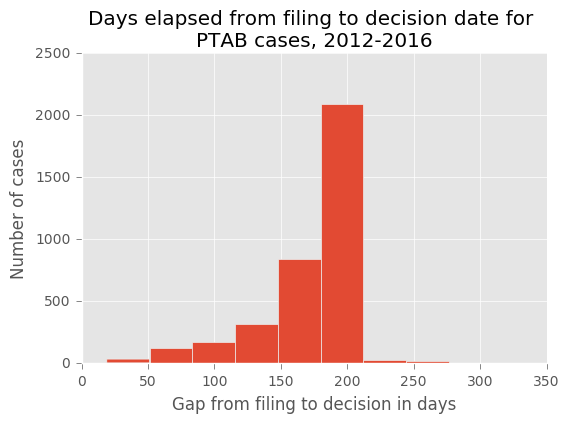

In [11]:
gap_in_days = df.filing_to_decision[df.filing_to_decision.notnull()] / np.timedelta64(1, 'D')
ax = plt.subplot(111)
gap_in_days.hist()
simpleaxis(ax)
plt.title('Days elapsed from filing to decision date for \nPTAB cases, 2012-2016')
plt.xlabel('Gap from filing to decision in days')
plt.ylabel('Number of cases')
plt.show()

In [12]:
# Eliminate any missing within the acceptable filing-to-decision gap
df.decision_date = pd.to_datetime(df.decision_date)
df.filing_date = pd.to_datetime(df.filing_date)

max_date = df.decision_date.max()
min_filing_date = max_date - pd.Timedelta('200 days')
df = df[(df.denied == 1) | (df.denied == 0) | ((df.denied == -1) & (df.filing_date < min_filing_date))]
df.denied[df.denied == -1] = 1

In [15]:
X = df.claim_text.as_matrix()
y = df.denied.as_matrix()

In [16]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
X_mod = []

for idx, claim in enumerate(X):
    text = ' '.join([word for word in claim.split() if word not in stop])
    X_mod.append(text)

In [17]:
# TFIDF

tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop)
X_unigram = tfidf_unigram.fit_transform(X_mod)

In [21]:
# Saving best model

best_clf = SVC(C=10, kernel='linear', probability=True)
model = best_clf.fit(X_unigram, y)

print("Training accuracy is {0}".format(model.score(X_unigram, y)))

# vals = df.invalidated.value_counts()
# print("Outcome of guessing is {}".format(float(vals[0])/float(sum(vals))))
# print("N is {0}".format(sum(vals)))

Training accuracy is 0.919868276619


In [22]:
X_unigram

<3644x16771 sparse matrix of type '<type 'numpy.float64'>'
	with 321308 stored elements in Compressed Sparse Row format>

In [23]:
with open('python_2_denials_tfidf.pkl', 'wb') as tfidf_file:
    pickle.dump(tfidf_unigram, tfidf_file)
with open('python_2_denials_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Model importing code

In [24]:
import pickle
import numpy as np

def get_denial_probability(text):
    """
    Get the probability that a PTAB case concerning a patent 
    will be denied.
    
    Keyword arguments:
    text -- text of the patent (string)
    """
    with open('python_2_denials_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)

    with open('python_2_denials_tfidf.pkl', 'rb') as vectorizer_file:
        tfidf = pickle.load(vectorizer_file)
        
    text_transformed = tfidf.transform([text])
    denial_probability = model.predict_proba(text_transformed)[0][1]
    
    return denial_probability

def get_top_denial_words(text, most_predictive=True):
    """
    Gets the words that are most predictive of patent denial (or lack thereof).
    
    Keyword arguments:
    text -- Text of the patent (string)
    most_predictive -- If True, function returns words from TEXT that are
                       most likely to predict denial. If False, function
                       returns words from TEXT that are least likely to
                       predict denial.
    """
        
    with open('python_2_denials_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)

    with open('python_2_denials_tfidf.pkl', 'rb') as vectorizer_file:
        tfidf = pickle.load(vectorizer_file)
        
    text_transformed = tfidf.transform([text])
    denial_probability = model.predict_proba(text_transformed)[0][1]
    
    coeffs = model.coef_
    mult = coeffs.multiply(text_transformed)
    word_labels = tfidf.get_feature_names()
    
    if most_predictive:
        top_word_indices = np.argsort(mult.todense().tolist()[0])[-3:][::-1]
        return [word_labels[idx] for idx in top_word_indices]
    
    else:
        bottom_word_indices = np.argsort(mult.todense().tolist()[0])[:3][::-1]
        return [word_labels[idx] for idx in bottom_word_indices]

In [30]:
get_denial_probability(text)

0.763540348570938

In [29]:
text = """
Trials@uspto.gov
571-272-7822

Paper No. 16
Entered: January 19, 2016

UNITED STATES PATENT AND TRADEMARK OFFICE
____________
BEFORE THE PATENT TRIAL AND APPEAL BOARD
____________
HEWLETT-PACKARD CO.,
Petitioner,
v.
U.S. PHILIPS CORPORATION, ORANGE, S.A., TDF SAS, and
INSTITUT FÜR RUNDFUNKTECHNIK GMBH,
Patent Owner.
____________
Case IPR2015-01507
Patent 5,323,396
____________

Before BRIAN J. MCNAMARA, SCOTT A. DANIELS, and
JENNIFER MEYER CHAGNON, Administrative Patent Judges.
CHAGNON, Administrative Patent Judge.

DECISION
Denying Institution of Inter Partes Review
37 C.F.R. § 42.108

I.

INTRODUCTION
Hewlett-Packard Co. (“Petitioner”) filed a Petition for inter partes

review of claims 1–33 (“the challenged claims”) of U.S. Patent
No. 5,323,396 (Ex. 1001, “the ’396 patent”). Paper 2 (“Pet.”). U.S. Philips

IPR2015-01507
Patent 5,323,396
Corporation, Orange, S.A., TDF SAS, and Institut Für Rundfunktechnik
GmbH (“Patent Owner”)1 timely filed a Preliminary Response. Paper 14
(“Prelim. Resp.”).
We have authority to determine whether to institute inter partes
review. See 35 U.S.C. § 314(b); 37 C.F.R. § 42.4(a). Upon consideration of
the Petition and the Preliminary Response, and for the reasons explained
below, we determine that the information presented fails to show a
reasonable likelihood that Petitioner would prevail with respect to any of the
challenged claims. See 35 U.S.C. § 314(a). Accordingly, we do not institute
trial as to any claim of the ’396 patent.
A. Related Proceedings
The ’396 patent has been asserted in Audio MPEG, Inc. v. HewlettPackard Co., No. 2:15-cv-00073 (E.D. Va.). Pet. 1; Paper 6, 2. Petitioner
also has filed two other Petitions for patents related to the ’396 patent—
IPR2015-01505 (U.S. Patent No. 5,777,992) and IPR2015-01506
(U.S. Patent No. 5,539,829).
B. The ’396 Patent and Illustrative Claim
The ’396 patent,2 titled “Digital Transmission System, Transmitter
and Receiver for Use in the Transmission System,” relates to a “flexible and
highly versatile transmission system” in which a “transmitter should be
capable of converting wide-band digital signals of different formats” into a
1

Patent Owner indicates Audio MPEG, Inc. is also a real-party-in-interest in
this proceeding. Paper 6, 2.
2
The ’396 patent was filed on December 21, 1992, and claims priority to a
U.S. application filed June 1, 1990, as well as to two Dutch patent
applications filed June 2, 1989 and February 13, 1990, respectively.
Ex. 1001, [22], [30], [63].
2

IPR2015-01507
Patent 5,323,396
second digital signal for transmission via a transmission medium, and in
which a “receiver should be capable of deriving a wide-band signal of the
correct format from said second digital signal.” Ex. 1001, 2:9–26.
Claim 1 of the ’396 patent, reproduced below, is illustrative of the
challenged claims:
1. A digital transmission system comprising a transmitter
and a receiver, for transmitting wide-band digital information
having a sample frequency Fs via a transmission medium, and
for receiving said information,
said transmitter having an input terminal for receiving
said information to be transmitted, in the form of a first digital
signal; an output; and a signal source, having an input coupled
to said input terminal, for generating and supplying to said
output a second digital signal which includes said information,
said second digital signal comprising consecutive frames, each
frame comprising a plurality of information packets, and each
information packet comprising N bits, where N>1,
said receiver comprising a decoder and an output
terminal, said decoder having an input for receiving said second
digital signal and an output coupled to said output terminal for
supplying said wide-band digital information,
characterized in that, in the formula
	 	

where BR is the bit rate of said second digital signal, and ns is
the number of samples of said information whose
corresponding information in said second signal is included in
one frame of said second signal,
if P is an integer, the number of information packets in
one frame is P, and
if P is not an integer, the number of information packets
in a number v of the frames is P’, where P’ is the highest
integer whose value is less than P; and the number of
information packets in a number w of the other frames is p'+1,
3

IPR2015-01507
Patent 5,323,396
the numbers v and w being selected such that the average frame
rate of said second digital signal is substantially equal to Fs/ns,
and that each frame comprises at least a first frame portion
including synchronizing information.
Ex. 1001, 24:34–25:6, Cert. of Corr.
C. The Applied References and Evidence
Petitioner relies on the following references. Pet. 2–3.
Reference
J.P. Chambers, Signalling in Parity: A
Brief History, British Broadcasting Corp.
(BBC) Research Department Report
1985/15 (Dec. 1985) (“Chambers”)
International Organization for
Standardization, FIFTH MPEG MEETING
REPORT, ISO-IED/JTC1/SC2/WG8N
(Feb. 1989) (“MPEG 89-051”)
G. Stoll, et al., Masking-Pattern Adapted
Subband Coding: Use of the Dynamic BitRate Margin (“MASCAM 1988”)

Date
Dec. 1985

Exhibit No.
1014

Feb. 1989

1010

Mar. 1988

1032

Petitioner further relies on the Declaration of Dr. Nikil Jayant
(Ex. 1004, “Jayant Declaration”).
D. The Asserted Grounds
Petitioner sets forth its challenges to claims 1–33 as follows. Pet. 2–3,
22–60.
References
Chambers and MPEG 89-051
Chambers, MPEG 89-051, and
MASCAM 1988
II.

Basis
§ 103
§ 103

Claims Challenged
1, 2, 24–28, 30–33
3–23, 29

CLAIM CONSTRUCTION
Because we do not reach the obviousness issues, based on our

determinations below, no claim construction is necessary.
4

IPR2015-01507
Patent 5,323,396
III.

ANALYSIS
Patentability challenges in an inter partes review must be “on the

basis of prior art consisting of patents or printed publications.” 35 U.S.C.
§ 311(b). Petitioner’s asserted grounds of unpatentability are based on three
non-patent references: Chambers, MPEG 89-051, and MASCAM 1988.
Pet. 2–3. Patent Owner asserts that Petitioner has not provided sufficient
evidence to show that any of these references is a printed publication.
Prelim. Resp. 8–18. The dispositive issue in this proceeding is whether
Petitioner has made a sufficient threshold showing that Chambers, which is
included in each asserted ground of unpatentability, is available as prior art
to the ’396 patent.
A. Legal Standard Regarding Prior Art Printed Publications
Petitioner has the initial burden of production of evidence establishing
that asserted references are applicable as prior art. Dynamic Drinkware LLC
v. Nat’l Graphics, Inc., 800 F.3d 1375, 1379 (Fed. Cir. 2015).
We look to the underlying facts to make a legal determination as to
whether a document is a printed publication. Suffolk Techs., LLC v. AOL
Inc., 752 F.3d 1358, 1364 (Fed. Cir. 2014). The determination of whether a
document is a “printed publication” under 35 U.S.C. § 102(b) involves a
case-by-case inquiry into the facts and circumstances surrounding its
disclosure to members of the public. In re Klopfenstein, 380 F.3d 1345,
1350 (Fed. Cir. 2004); see also In re Hall, 781 F.2d 897, 898–99 (Fed. Cir.
1986) (holding that “public accessibility” is the touchstone in determining
whether a reference is a “printed publication” under § 102).
To qualify as a printed publication, a document “must have been
sufficiently accessible to the public interested in the art.” In re Lister,
5

IPR2015-01507
Patent 5,323,396
583 F.3d 1307, 1311 (Fed. Cir. 2009). The party seeking to introduce the
reference “should produce sufficient proof of its dissemination or that it has
otherwise been available and accessible to persons concerned with the art to
which the document relates and thus most likely to avail themselves of its
contents.” In re Wyer, 655 F.2d 221, 227 (CCPA 1981) (citation omitted);
see also Cordis Corp. v. Boston Sci. Corp., 561 F.3d 1319, 1333 (Fed. Cir.
2009) (holding that a “document is publicly accessible if it ‘has been
disseminated or otherwise made available to the extent that persons
interested and ordinarily skilled in the subject matter or art, exercising
reasonable diligence, can locate it’” (citing In re Wyer, 655 F.2d at 226)).
B. Whether Chambers is Available as Prior Art
Petitioner asserts that Chambers “qualif[ies] as prior art under at least
35 U.S.C. § 102(b). Specifically, Chambers . . . was published in December
1985, . . . more than a year before the earliest priority date of the ‘396
Patent.” Pet. 3. The Petition, however, points to no specific evidence
supporting its assertion that Chambers was published in 1985.3

3

In an email to the Board on December 14, 2015 seeking authorization to
file a Reply to Patent Owner’s Preliminary Response, Petitioner asserted that
it “was surprised to see [Patent Owner’s] arguments” regarding the prior art
status of Chambers and MASCAM 1988 “[b]ecause Patent Owner[] had not
ever disputed that Chambers was prior art in previous ex parte reexams, and
because Patent Owner[] had submitted MASCAM 1988 as prior art in
previous Information Disclosure Statements.” We did not authorize
additional briefing on this issue. See Paper 15. We are not persuaded that
Patent Owner’s choice not to challenge Chambers’s prior art status in a
reexamination proceeding, or Patent Owner’s submission of MASCAM
1988 in an IDS, relieves Petitioner of its initial burden to put forth evidence
in this inter partes review proceeding that the documents are available as
prior art to the ’396 patent.
6

IPR2015-01507
Patent 5,323,396
On its face, Chambers includes a “December 1985” date, as well as a
“BBC RD 1985/15” indication. Ex. 1014,4 1. The fact that a date is printed
on the face of a reference, without more, is not enough to establish that the
reference was publicly accessible on that date. See LG Elecs., Inc. v.
Advanced Micro Devices, Inc., Case IPR2015-00329, slip op. at 13 (PTAB
July 10, 2015) (Paper 13); see also Google Inc. v. ART+COM
Innovationpool GmbH, Case IPR2015-00788, slip op. at 8 (PTAB Sept. 2,
2015) (Paper 7) (“[T]his bare date, without more, does not provide any
information about the date [the reference] was publicly accessible.”).
Further, the unsupported testimony of Dr. Jayant that “[Chambers] was
published in December 1985” (Ex. 1004 ¶ 94) also is insufficient to
demonstrate that Chambers was published in December 1985.
Patent Owner argues that the Petition includes no arguments or
evidence regarding “whether or how Chambers was distributed, or, if it was
distributed, whether that distribution was limited or subject to any
confidentiality restrictions.” Prelim. Resp. 12. Although Chambers is dated
December 1985 on its face, Petitioner provides no evidence concerning
when it was first published or distributed. In particular, Petitioner provides
no evidence that the British Broadcasting Corporation (“BBC”) made
Chambers publicly available in 1985, or how an interested person would
have located it. Petitioner likewise provides no evidence concerning the
general publication or distribution policies of the BBC.
Further, as noted by Patent Owner, Chambers includes other
information within the document itself that is inconsistent with a
4

Citations to Ex. 1014 are to page numbers added by Petitioner at the
bottom of each page.
7

IPR2015-01507
Patent 5,323,396
December 1985 publication date. See Prelim. Resp. 13. For example,
Chambers includes a copyright notice that is nearly 20 years after the alleged
December 1985 publication date—namely, “© BBC 2004”. Ex. 1014, 6.
Further, the “References” section of Chambers includes at least one citation
to a paper apparently published in February 1986, which also is after the
alleged December 1985 publication date. Ex. 1014, 18. These dates are
inconsistent with the December 1985 date printed on the face of the
document, and cast further doubt as to the public availability thereof as of
December 1985. Petitioner, however, makes no attempt to address or
explain these inconsistencies.
Accordingly, based on the evidence provided in the Petition, we
conclude Petitioner has not made a sufficient threshold showing that
Chambers is available as prior art in this proceeding.
C. Asserted Grounds of Unpatentability
Each asserted ground of unpatentability relies, in part, on Chambers.
Because Petitioner has not met its burden in making a sufficient threshold
showing that Chambers is available as prior art to the ’396 patent,5 Petitioner
also has not shown a reasonable likelihood of prevailing on either asserted
ground of unpatentability.

5

As noted above, Patent Owner also asserts that Petitioner has not made a
sufficient showing regarding the prior art status of MPEG 89-051 and
MASCAM 1988. Because we determine Petitioner has not made a sufficient
showing regarding the prior art status of Chambers, we need not reach the
issue regarding MPEG 89-051 and MASCAM 1988.
8

IPR2015-01507
Patent 5,323,396
IV.

CONCLUSION
For the foregoing reasons, we determine that the information

presented in the Petition fails to establish a reasonable likelihood that
Petitioner would prevail on any alleged ground of unpatentability with
respect to the challenged claims of the ’396 patent.
V.

ORDER
Accordingly, it is
ORDERED that pursuant to 35 U.S.C. § 314(a), the Petition is denied

and no trial is instituted.

9

IPR2015-01507
Patent 5,323,396
PETITIONER:
Walter Renner
Roberto Devoto
FISH & RICHARDSON P.C.
IPR18296-0056IP1@fr.com
PATENT OWNER:
Stephen Elliott
James Williams
SULLIVAN & CROMWELL LLP
elliotts@sullcrom.com
williamsj@sullcrom.com

10

"""

In [26]:
get_top_denial_words("it was a cold dark night and there were many biochemical reactions. it was a tough place to be.")

[u'many', u'dark', u'enlarging']

In [32]:
def get_top_keywords(text, mode='denials', most_predictive=True):
    """
    Gets the words that are most predictive of patent denial/invalidation (or lack thereof).
    
    Keyword arguments:
    text -- Text of the patent (string)
    mode -- Predict invalidation or denials (string)
    most_predictive -- If true, function returns words from TEXT that are
                       most likely to predict denial. If false, function
                       returns words from TEXT that are least likely to
                       predict denial. (boolean)
    """
        
    with open('python_2_denials_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)

    with open('python_2_denials_tfidf.pkl', 'rb') as vectorizer_file:
        tfidf = pickle.load(vectorizer_file)
        
    text_transformed = tfidf.transform([text])
    predicted_probability = model.predict_proba(text_transformed)[0][1]
    
    coeffs = model.coef_
    mult = np.multiply(coeffs, text_transformed.toarray())
    word_labels = tfidf.get_feature_names()

    if most_predictive:
        top_word_indices = np.argsort(mult)[0][-3:][::-1]
        return [word_labels[idx] for idx in top_word_indices]
    
    else:
        bottom_word_indices = np.argsort(mult)[0][:3][::-1]
        return [word_labels[idx] for idx in bottom_word_indices]

In [34]:
get_top_keywords(text)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/encodings/utf_8.py", line 16, in decode
    return codecs.utf_8_decode(input, errors, True)
KeyboardInterrupt


IndexError: string index out of range